In [1]:
import pandas as pd
%pylab  inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('bank_data.csv')

In [9]:
print(len(data))
print(len(data.columns))

39527
20


In [7]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [20]:
# y = [1 if x == 'yes' else 0 for x in data['y']]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['y'])
y = le.transform(data['y'])

In [21]:
X = data
del X['y']

In [25]:
X = pd.get_dummies(X)

In [28]:
from sklearn.cross_validation import train_test_split, StratifiedKFold, StratifiedShuffleSplit

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
strat_X_train, strat_X_test, strat_y_train, strat_y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [35]:
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=0)

In [36]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression

In [38]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=cv, scoring='roc_auc')

In [39]:
scores

array([ 0.78208568,  0.78913702,  0.78905665,  0.78791899,  0.78996617])

In [40]:
print(scores.mean())
print(scores.std())

0.787632903867
0.00284910751406


In [43]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [47]:
tree_params={'max_depth': list(range(1, 20)), "criterion": ['gini', 'entropy']}

In [48]:
tree_model = GridSearchCV(DecisionTreeClassifier(), tree_params, scoring='roc_auc', cv=cv)

In [50]:
%%time
tree_model.fit(X_train, y_train)

CPU times: user 17.5 s, sys: 24 ms, total: 17.5 s
Wall time: 17.5 s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=5, shuffle=True, random_state=0),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [66]:
print(tree_model.best_params_)
print(tree_model.best_score_)
print(tree_model.best_estimator_)

{'max_depth': 5, 'criterion': 'entropy'}
0.781830539031
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [54]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf_params =  {"n_estimators": list(range(1, 100)), "criterion": ['gini', 'entropy']}

In [61]:
rf_model = GridSearchCV(RandomForestClassifier(), tree_params, scoring='roc_auc', cv=cv)

In [62]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 23.2 s, sys: 16 ms, total: 23.2 s
Wall time: 23.5 s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=5, shuffle=True, random_state=0),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [67]:
print(rf_model.best_params_)
print(rf_model.best_score_)
print(rf_model.best_estimator_)

{'max_depth': 8, 'criterion': 'gini'}
0.796630759953
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [79]:
my_range = list(range(1, 20))

In [80]:
means = []
stds = []
for i in my_range:
    scores = cross_val_score(RandomForestClassifier(n_estimators=i), X_train, y_train,
                            scoring='roc_auc', cv=cv)
    means.append(scores.mean())
    stds.append(scores.std())

In [81]:
import matplotlib.pyplot as plt
import seaborn

<Container object of 3 artists>

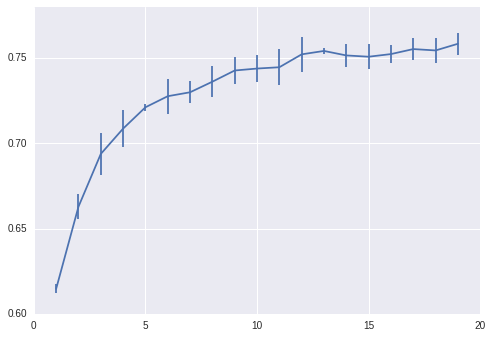

In [82]:
plt.errorbar(my_range, means, stds)

### Method 3 Feature Selection

In [84]:
selector = LogisticRegression(penalty="l1", C=0.1, n_jobs=3)
selector.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
selector.transform(X_train).shape

/usr/local/lib/python3.5/dist-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(27668, 34)

In [88]:
X_train.shape

(27668, 62)

In [85]:
from sklearn.feature_selection import SelectFromModel  # to find out how to use

In [89]:
from sklearn.pipeline import Pipeline

In [91]:
my_pipe = Pipeline([("selection", selector),
                    ("learning", LogisticRegression()) ])

In [92]:
scores = cross_val_score(my_pipe, X_train, y_train, cv=cv, scoring='roc_auc')

/usr/local/lib/python3.5/dist-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as fe

In [93]:
scores.mean()

0.78481078400162119

In [94]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [107]:
def get_report(model, model_label=""):
    pred = model.predict_proba(X_test)
    fpr, tpr, thr_roc = roc_curve(y_test, pred[:, 1])
    pre, rec, thr_pr = precision_recall_curve(y_test, pred[:, 1])
    print(roc_auc_score(y_test, pred[:, 1]))
    plt.plot(fpr, tpr, label=model_label)
    plt.plot(rec, pre, label=model_label)
    plt.legend()

0.79378687106
0.783987197636
0.792534042484


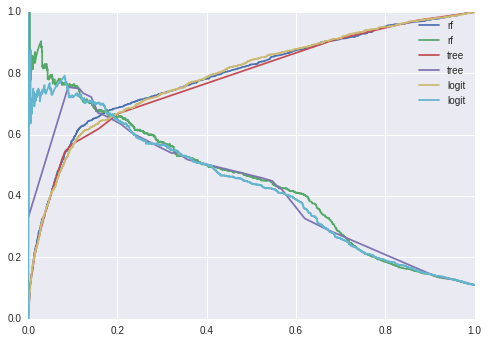

In [108]:
get_report(rf_model, "rf")
get_report(tree_model, "tree")
get_report(selector, "logit")

http://xgboost.readthedocs.io/en/latest/python/python_intro.html